In [41]:
import torch
from torch.utils.data import Dataset
import torchvision
from PIL import Image
import requests
from io import BytesIO
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

In [44]:


class LazyRotationImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super(LazyRotationImageDataset, self).__init__()
        self.data = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in sorted(filenames)]
        self.rotations = [0, 90, 180, 270]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        rotation_idx = torch.randint(0, 4, (1,)).item()  # Random index for rotation
        rotation_angle = self.rotations[rotation_idx]  # Corresponding rotation angle

        rotation_transform = transforms.Compose([
            transforms.RandomRotation([rotation_angle, rotation_angle], expand=True),
            transforms.ToTensor()
        ])

        rotated_image = rotation_transform(image)  # Applies the selected rotation
        return rotated_image, rotation_idx

# Example usage
dataset = LazyRotationImageDataset("../../resized")
# dataset = LazyRotationImageDataset("/content/")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Now you can use this dataloader in your training loop

In [45]:
len(dataset)

9435

In [46]:
import os
import shutil

dir_path = "../../"  # replace with your directory path
image_dir = os.path.join(dir_path, "resized")

# Create the images subdirectory if it doesn't exist
os.makedirs(image_dir, exist_ok=True)

# Iterate over all files in the directory
for file in os.listdir(dir_path):
    # If the file is a .jpg image
    if file.endswith(".jpg"):
        # Move it to the images subdirectory
        shutil.move(os.path.join(dir_path, file), os.path.join(image_dir, file))

In [47]:
from tqdm import tqdm

# Model modification to predict rotation
class RotationPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)  # Predicting 4 rotation classes

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RotationPredictor().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
epochs = 20
for epoch in range(epochs):
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

torch.save(model.state_dict(), "model_final.pt")

# Now the model is fine-tuned to predict rotations, which also improves its feature extraction capability

100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:43<00:00,  2.86it/s]


Epoch 1/20, Loss: 0.3104051649570465


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:35<00:00,  3.08it/s]


Epoch 2/20, Loss: 0.34103161096572876


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:36<00:00,  3.07it/s]


Epoch 3/20, Loss: 0.13197872042655945


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:36<00:00,  3.06it/s]


Epoch 4/20, Loss: 0.1446947604417801


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:36<00:00,  3.05it/s]


Epoch 5/20, Loss: 0.12978607416152954


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:36<00:00,  3.05it/s]


Epoch 6/20, Loss: 0.2433975487947464


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:36<00:00,  3.05it/s]


Epoch 7/20, Loss: 0.2211100310087204


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:36<00:00,  3.04it/s]


Epoch 8/20, Loss: 0.1395188719034195


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:36<00:00,  3.04it/s]


Epoch 9/20, Loss: 0.12773703038692474


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.04it/s]


Epoch 10/20, Loss: 0.06184835731983185


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.04it/s]


Epoch 11/20, Loss: 0.09226543456315994


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.04it/s]


Epoch 12/20, Loss: 0.056391578167676926


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.03it/s]


Epoch 13/20, Loss: 0.16623710095882416


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.04it/s]


Epoch 14/20, Loss: 0.02321883663535118


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.03it/s]


Epoch 15/20, Loss: 0.025790728628635406


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.03it/s]


Epoch 16/20, Loss: 0.017741713672876358


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.03it/s]


Epoch 17/20, Loss: 0.067864790558815


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.03it/s]


Epoch 18/20, Loss: 0.06877843290567398


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.03it/s]


Epoch 19/20, Loss: 0.03744351118803024


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:37<00:00,  3.03it/s]


Epoch 20/20, Loss: 0.030180905014276505


In [48]:
# Load the entire model (architecture + weights)
#model = torch.load('model.pt')

In [49]:
def count_parameters(model):
	return sum(p.numel() for p in model.parameters())


In [50]:
count_parameters(model)

11178564

In [51]:
model.eval()
import copy

resnet_pretrained = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_pretrained = nn.Sequential(*list(resnet_pretrained.children())[:-4], nn.AdaptiveAvgPool2d((1, 1)))
resnet_pretrained = torch.quantization.quantize_dynamic(
	resnet_pretrained, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
)


model_finetunned = copy.deepcopy(model.resnet)
model_finetunned = nn.Sequential(*list(model_finetunned.children())[:-4], nn.AdaptiveAvgPool2d((1, 1)))
model_finetunned = torch.quantization.quantize_dynamic(
	model_finetunned, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
)

count_parameters(resnet_pretrained), count_parameters(model_finetunned)

(683072, 683072)

In [52]:
model

RotationPredictor(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [53]:
resnet_pretrained

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [54]:
model(dataset[0][0].to(device).unsqueeze(0))

tensor([[-4.8604,  8.0539, -6.0772, -2.7861]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [55]:
resnet_pretrained = resnet_pretrained.to("cpu")
features_pretrained = torch.zeros((len(dataset), 128))


In [56]:
for i, (images, labels) in tqdm(enumerate(dataloader)):
    print(f"{i}")
    # images = images
    # labels = labels
    outputs = resnet_pretrained(images).squeeze().detach()
    features_pretrained[i * 32: i * 32 + len(images)] = outputs

0it [00:00, ?it/s]

0


1it [00:01,  1.10s/it]

1


2it [00:02,  1.10s/it]

2


3it [00:03,  1.10s/it]

3


4it [00:04,  1.09s/it]

4


5it [00:05,  1.09s/it]

5


6it [00:06,  1.08s/it]

6


7it [00:07,  1.09s/it]

7


8it [00:08,  1.11s/it]

8


9it [00:09,  1.12s/it]

9


10it [00:11,  1.12s/it]

10


11it [00:12,  1.12s/it]

11


12it [00:13,  1.12s/it]

12


13it [00:14,  1.14s/it]

13


14it [00:15,  1.18s/it]

14


15it [00:17,  1.24s/it]

15


16it [00:18,  1.25s/it]

16


17it [00:19,  1.27s/it]

17


18it [00:21,  1.38s/it]

18


19it [00:22,  1.46s/it]

19


20it [00:24,  1.42s/it]

20


21it [00:25,  1.35s/it]

21


22it [00:26,  1.30s/it]

22


23it [00:27,  1.25s/it]

23


24it [00:28,  1.22s/it]

24


25it [00:30,  1.19s/it]

25


26it [00:31,  1.15s/it]

26


27it [00:32,  1.16s/it]

27


28it [00:33,  1.16s/it]

28


29it [00:34,  1.16s/it]

29


30it [00:35,  1.16s/it]

30


31it [00:36,  1.15s/it]

31


32it [00:38,  1.16s/it]

32


33it [00:39,  1.14s/it]

33


34it [00:40,  1.17s/it]

34


35it [00:41,  1.19s/it]

35


36it [00:42,  1.18s/it]

36


37it [00:44,  1.19s/it]

37


38it [00:45,  1.19s/it]

38


39it [00:46,  1.20s/it]

39


40it [00:47,  1.20s/it]

40


41it [00:48,  1.20s/it]

41


42it [00:50,  1.20s/it]

42


43it [00:51,  1.21s/it]

43


44it [00:52,  1.22s/it]

44


45it [00:53,  1.21s/it]

45


46it [00:54,  1.20s/it]

46


47it [00:56,  1.21s/it]

47


48it [00:57,  1.21s/it]

48


49it [00:58,  1.21s/it]

49


50it [00:59,  1.20s/it]

50


51it [01:00,  1.20s/it]

51


52it [01:02,  1.19s/it]

52


53it [01:03,  1.21s/it]

53


54it [01:04,  1.20s/it]

54


55it [01:05,  1.20s/it]

55


56it [01:06,  1.20s/it]

56


57it [01:08,  1.21s/it]

57


58it [01:09,  1.21s/it]

58


59it [01:10,  1.21s/it]

59


60it [01:11,  1.22s/it]

60


61it [01:13,  1.24s/it]

61


62it [01:14,  1.25s/it]

62


63it [01:15,  1.23s/it]

63


64it [01:16,  1.20s/it]

64


65it [01:17,  1.21s/it]

65


66it [01:19,  1.24s/it]

66


67it [01:20,  1.23s/it]

67


68it [01:21,  1.21s/it]

68


69it [01:22,  1.22s/it]

69


70it [01:24,  1.22s/it]

70


71it [01:25,  1.23s/it]

71


72it [01:26,  1.23s/it]

72


73it [01:27,  1.21s/it]

73


74it [01:29,  1.23s/it]

74


75it [01:30,  1.22s/it]

75


76it [01:31,  1.20s/it]

76


77it [01:32,  1.21s/it]

77


78it [01:33,  1.21s/it]

78


79it [01:35,  1.20s/it]

79


80it [01:36,  1.22s/it]

80


81it [01:37,  1.22s/it]

81


82it [01:38,  1.21s/it]

82


83it [01:39,  1.21s/it]

83


84it [01:41,  1.21s/it]

84


85it [01:42,  1.20s/it]

85


86it [01:43,  1.20s/it]

86


87it [01:44,  1.19s/it]

87


88it [01:45,  1.18s/it]

88


89it [01:46,  1.18s/it]

89


90it [01:48,  1.19s/it]

90


91it [01:49,  1.19s/it]

91


92it [01:50,  1.19s/it]

92


93it [01:51,  1.19s/it]

93


94it [01:53,  1.21s/it]

94


95it [01:54,  1.20s/it]

95


96it [01:55,  1.20s/it]

96


97it [01:56,  1.19s/it]

97


98it [01:57,  1.18s/it]

98


99it [01:58,  1.19s/it]

99


100it [02:00,  1.19s/it]

100


101it [02:01,  1.19s/it]

101


102it [02:02,  1.18s/it]

102


103it [02:03,  1.18s/it]

103


104it [02:04,  1.17s/it]

104


105it [02:05,  1.17s/it]

105


106it [02:07,  1.17s/it]

106


107it [02:08,  1.18s/it]

107


108it [02:09,  1.18s/it]

108


109it [02:10,  1.18s/it]

109


110it [02:11,  1.19s/it]

110


111it [02:13,  1.18s/it]

111


112it [02:14,  1.19s/it]

112


113it [02:15,  1.22s/it]

113


114it [02:16,  1.22s/it]

114


115it [02:18,  1.21s/it]

115


116it [02:19,  1.21s/it]

116


117it [02:20,  1.21s/it]

117


118it [02:21,  1.20s/it]

118


119it [02:22,  1.21s/it]

119


120it [02:23,  1.19s/it]

120


121it [02:25,  1.18s/it]

121


122it [02:26,  1.23s/it]

122


123it [02:27,  1.22s/it]

123


124it [02:28,  1.23s/it]

124


125it [02:30,  1.21s/it]

125


126it [02:31,  1.20s/it]

126


127it [02:32,  1.20s/it]

127


128it [02:33,  1.18s/it]

128


129it [02:34,  1.18s/it]

129


130it [02:35,  1.19s/it]

130


131it [02:37,  1.23s/it]

131


132it [02:38,  1.24s/it]

132


133it [02:39,  1.26s/it]

133


134it [02:41,  1.24s/it]

134


135it [02:42,  1.23s/it]

135


136it [02:43,  1.22s/it]

136


137it [02:44,  1.22s/it]

137


138it [02:46,  1.25s/it]

138


139it [02:47,  1.24s/it]

139


140it [02:48,  1.21s/it]

140


141it [02:49,  1.20s/it]

141


142it [02:50,  1.20s/it]

142


143it [02:51,  1.20s/it]

143


144it [02:53,  1.21s/it]

144


145it [02:54,  1.21s/it]

145


146it [02:55,  1.20s/it]

146


147it [02:56,  1.19s/it]

147


148it [02:57,  1.19s/it]

148


149it [02:59,  1.19s/it]

149


150it [03:00,  1.18s/it]

150


151it [03:01,  1.17s/it]

151


152it [03:02,  1.20s/it]

152


153it [03:03,  1.21s/it]

153


154it [03:05,  1.19s/it]

154


155it [03:06,  1.18s/it]

155


156it [03:07,  1.19s/it]

156


157it [03:08,  1.19s/it]

157


158it [03:09,  1.19s/it]

158


159it [03:11,  1.20s/it]

159


160it [03:12,  1.19s/it]

160


161it [03:13,  1.19s/it]

161


162it [03:14,  1.18s/it]

162


163it [03:15,  1.19s/it]

163


164it [03:16,  1.19s/it]

164


165it [03:18,  1.18s/it]

165


166it [03:19,  1.17s/it]

166


167it [03:20,  1.19s/it]

167


168it [03:21,  1.19s/it]

168


169it [03:22,  1.19s/it]

169


170it [03:24,  1.20s/it]

170


171it [03:25,  1.20s/it]

171


172it [03:26,  1.19s/it]

172


173it [03:27,  1.19s/it]

173


174it [03:28,  1.18s/it]

174


175it [03:30,  1.18s/it]

175


176it [03:31,  1.19s/it]

176


177it [03:32,  1.21s/it]

177


178it [03:33,  1.21s/it]

178


179it [03:34,  1.21s/it]

179


180it [03:36,  1.21s/it]

180


181it [03:37,  1.23s/it]

181


182it [03:38,  1.24s/it]

182


183it [03:39,  1.23s/it]

183


184it [03:41,  1.21s/it]

184


185it [03:42,  1.21s/it]

185


186it [03:43,  1.20s/it]

186


187it [03:44,  1.20s/it]

187


188it [03:45,  1.18s/it]

188


189it [03:46,  1.19s/it]

189


190it [03:48,  1.20s/it]

190


191it [03:49,  1.23s/it]

191


192it [03:50,  1.22s/it]

192


193it [03:51,  1.21s/it]

193


194it [03:53,  1.20s/it]

194


195it [03:54,  1.21s/it]

195


196it [03:55,  1.21s/it]

196


197it [03:56,  1.20s/it]

197


198it [03:57,  1.19s/it]

198


199it [03:58,  1.18s/it]

199


200it [04:00,  1.17s/it]

200


201it [04:01,  1.18s/it]

201


202it [04:02,  1.17s/it]

202


203it [04:03,  1.18s/it]

203


204it [04:04,  1.18s/it]

204


205it [04:06,  1.18s/it]

205


206it [04:07,  1.17s/it]

206


207it [04:08,  1.19s/it]

207


208it [04:09,  1.18s/it]

208


209it [04:10,  1.18s/it]

209


210it [04:11,  1.19s/it]

210


211it [04:13,  1.19s/it]

211


212it [04:14,  1.18s/it]

212


213it [04:15,  1.17s/it]

213


214it [04:16,  1.18s/it]

214


215it [04:17,  1.17s/it]

215


216it [04:19,  1.19s/it]

216


217it [04:20,  1.19s/it]

217


218it [04:21,  1.19s/it]

218


219it [04:22,  1.19s/it]

219


220it [04:23,  1.18s/it]

220


221it [04:24,  1.19s/it]

221


222it [04:26,  1.18s/it]

222


223it [04:27,  1.18s/it]

223


224it [04:28,  1.18s/it]

224


225it [04:29,  1.18s/it]

225


226it [04:30,  1.17s/it]

226


227it [04:32,  1.18s/it]

227


228it [04:33,  1.17s/it]

228


229it [04:34,  1.17s/it]

229


230it [04:35,  1.17s/it]

230


231it [04:36,  1.19s/it]

231


232it [04:37,  1.18s/it]

232


233it [04:39,  1.18s/it]

233


234it [04:40,  1.17s/it]

234


235it [04:41,  1.18s/it]

235


236it [04:42,  1.18s/it]

236


237it [04:43,  1.18s/it]

237


238it [04:45,  1.21s/it]

238


239it [04:46,  1.23s/it]

239


240it [04:47,  1.23s/it]

240


241it [04:48,  1.20s/it]

241


242it [04:49,  1.19s/it]

242


243it [04:51,  1.18s/it]

243


244it [04:52,  1.18s/it]

244


245it [04:53,  1.18s/it]

245


246it [04:54,  1.18s/it]

246


247it [04:55,  1.21s/it]

247


248it [04:57,  1.21s/it]

248


249it [04:58,  1.21s/it]

249


250it [04:59,  1.19s/it]

250


251it [05:00,  1.18s/it]

251


252it [05:01,  1.17s/it]

252


253it [05:02,  1.18s/it]

253


254it [05:04,  1.18s/it]

254


255it [05:05,  1.19s/it]

255


256it [05:06,  1.18s/it]

256


257it [05:07,  1.17s/it]

257


258it [05:08,  1.17s/it]

258


259it [05:10,  1.20s/it]

259


260it [05:11,  1.20s/it]

260


261it [05:12,  1.20s/it]

261


262it [05:13,  1.19s/it]

262


263it [05:14,  1.19s/it]

263


264it [05:16,  1.19s/it]

264


265it [05:17,  1.20s/it]

265


266it [05:18,  1.18s/it]

266


267it [05:19,  1.19s/it]

267


268it [05:20,  1.21s/it]

268


269it [05:22,  1.21s/it]

269


270it [05:23,  1.20s/it]

270


271it [05:24,  1.19s/it]

271


272it [05:25,  1.19s/it]

272


273it [05:26,  1.19s/it]

273


274it [05:27,  1.18s/it]

274


275it [05:29,  1.17s/it]

275


276it [05:30,  1.19s/it]

276


277it [05:31,  1.20s/it]

277


278it [05:32,  1.27s/it]

278


279it [05:34,  1.36s/it]

279


280it [05:36,  1.47s/it]

280


281it [05:37,  1.50s/it]

281


282it [05:39,  1.51s/it]

282


283it [05:41,  1.61s/it]

283


284it [05:42,  1.63s/it]

284


285it [05:44,  1.59s/it]

285


286it [05:45,  1.52s/it]

286


287it [05:47,  1.45s/it]

287


288it [05:48,  1.37s/it]

288


289it [05:49,  1.30s/it]

289


290it [05:50,  1.27s/it]

290


291it [05:51,  1.24s/it]

291


292it [05:52,  1.22s/it]

292


293it [05:54,  1.20s/it]

293


294it [05:55,  1.20s/it]

294


295it [05:56,  1.21s/it]


In [57]:
features_pretrained
torch.save(features_pretrained, "tens.pt")

In [58]:
def get_image_names(directory):
    image_extensions = '.jpg'
    image_names = []
    for filename in sorted(os.listdir(directory)):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_names.append(filename)
    return image_names

directory = "../../resized"
image_names = get_image_names(directory)
print(image_names)

['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg', '1015.jpg', '1016.jpg', '1017.jpg', '1018.jpg', '1019.jpg', '102.jpg', '1020.jpg', '1021.jpg', '1022.jpg', '1023.jpg', '1024.jpg', '1025.jpg', '1026.jpg', '1027.jpg', '1028.jpg', '1029.jpg', '103.jpg', '1030.jpg', '1031.jpg', '1032.jpg', '1033.jpg', '1034.jpg', '1035.jpg', '1036.jpg', '1037.jpg', '1038.jpg', '1039.jpg', '104.jpg', '1040.jpg', '1041.jpg', '1042.jpg', '1043.jpg', '1044.jpg', '1045.jpg', '1046.jpg', '1047.jpg', '1048.jpg', '1049.jpg', '105.jpg', '1050.jpg', '1051.jpg', '1052.jpg', '1053.jpg', '1054.jpg', '1055.jpg', '1056.jpg', '1057.jpg', '1058.jpg', '1059.jpg', '106.jpg', '1060.jpg', '1061.jpg', '1062.jpg', '1063.jpg', '1064.jpg', '1065.jpg', '1066.jpg', '1067.jpg', '1068.jpg', '1069.jpg', '107.jpg', '1070.jpg', '1071.jpg', '1072.jpg', '1073.j

In [59]:
pretrained_matrix = []

for image, vector in zip(image_names, features_pretrained):
    pretrained_matrix.append([image, vector])

In [60]:
model_finetunned = model_finetunned.to("cpu")
features_finetunning = torch.zeros((len(dataset), 128))


In [61]:
for i, (images, labels) in tqdm(enumerate(dataloader)):
    print(f"{i}")
    # images = images
    # labels = labels
    outputs = model_finetunned(images).squeeze().detach()
    features_finetunning[i * 32: i * 32 + len(images)] = outputs

0it [00:00, ?it/s]

0


1it [00:01,  1.22s/it]

1


2it [00:02,  1.16s/it]

2


3it [00:03,  1.13s/it]

3


4it [00:04,  1.10s/it]

4


5it [00:05,  1.11s/it]

5


6it [00:06,  1.10s/it]

6


7it [00:07,  1.10s/it]

7


8it [00:08,  1.10s/it]

8


9it [00:09,  1.10s/it]

9


10it [00:11,  1.10s/it]

10


11it [00:12,  1.11s/it]

11


12it [00:13,  1.09s/it]

12


13it [00:14,  1.10s/it]

13


14it [00:15,  1.09s/it]

14


15it [00:16,  1.10s/it]

15


16it [00:17,  1.10s/it]

16


17it [00:18,  1.10s/it]

17


18it [00:19,  1.10s/it]

18


19it [00:21,  1.16s/it]

19


20it [00:22,  1.17s/it]

20


21it [00:23,  1.17s/it]

21


22it [00:24,  1.18s/it]

22


23it [00:25,  1.18s/it]

23


24it [00:27,  1.18s/it]

24


25it [00:28,  1.18s/it]

25


26it [00:29,  1.18s/it]

26


27it [00:30,  1.17s/it]

27


28it [00:31,  1.18s/it]

28


29it [00:32,  1.17s/it]

29


30it [00:34,  1.17s/it]

30


31it [00:35,  1.17s/it]

31


32it [00:36,  1.17s/it]

32


33it [00:37,  1.17s/it]

33


34it [00:38,  1.17s/it]

34


35it [00:40,  1.18s/it]

35


36it [00:41,  1.18s/it]

36


37it [00:42,  1.18s/it]

37


38it [00:43,  1.18s/it]

38


39it [00:44,  1.19s/it]

39


40it [00:45,  1.18s/it]

40


41it [00:47,  1.18s/it]

41


42it [00:48,  1.19s/it]

42


43it [00:49,  1.20s/it]

43


44it [00:50,  1.23s/it]

44


45it [00:52,  1.26s/it]

45


46it [00:53,  1.23s/it]

46


47it [00:54,  1.24s/it]

47


48it [00:55,  1.23s/it]

48


49it [00:57,  1.24s/it]

49


50it [00:58,  1.23s/it]

50


51it [00:59,  1.37s/it]

51


52it [01:01,  1.37s/it]

52


53it [01:02,  1.35s/it]

53


54it [01:03,  1.30s/it]

54


55it [01:05,  1.28s/it]

55


56it [01:06,  1.25s/it]

56


57it [01:07,  1.24s/it]

57


58it [01:08,  1.24s/it]

58


59it [01:09,  1.23s/it]

59


60it [01:11,  1.22s/it]

60


61it [01:12,  1.25s/it]

61


62it [01:13,  1.24s/it]

62


63it [01:14,  1.22s/it]

63


64it [01:16,  1.23s/it]

64


65it [01:17,  1.21s/it]

65


66it [01:18,  1.20s/it]

66


67it [01:19,  1.21s/it]

67


68it [01:20,  1.23s/it]

68


69it [01:22,  1.24s/it]

69


70it [01:23,  1.23s/it]

70


71it [01:24,  1.22s/it]

71


72it [01:25,  1.21s/it]

72


73it [01:26,  1.20s/it]

73


74it [01:28,  1.24s/it]

74


75it [01:29,  1.29s/it]

75


76it [01:30,  1.29s/it]

76


77it [01:32,  1.27s/it]

77


78it [01:33,  1.26s/it]

78


79it [01:34,  1.30s/it]

79


80it [01:35,  1.27s/it]

80


81it [01:37,  1.28s/it]

81


82it [01:38,  1.26s/it]

82


83it [01:39,  1.23s/it]

83


84it [01:40,  1.22s/it]

84


85it [01:42,  1.21s/it]

85


86it [01:43,  1.20s/it]

86


87it [01:44,  1.20s/it]

87


88it [01:45,  1.23s/it]

88


89it [01:47,  1.25s/it]

89


90it [01:48,  1.27s/it]

90


91it [01:49,  1.25s/it]

91


92it [01:50,  1.23s/it]

92


93it [01:51,  1.21s/it]

93


94it [01:53,  1.19s/it]

94


95it [01:54,  1.19s/it]

95


96it [01:55,  1.18s/it]

96


97it [01:56,  1.18s/it]

97


98it [01:57,  1.18s/it]

98


99it [01:58,  1.18s/it]

99


100it [02:00,  1.21s/it]

100


101it [02:01,  1.20s/it]

101


102it [02:02,  1.20s/it]

102


103it [02:03,  1.18s/it]

103


104it [02:04,  1.18s/it]

104


105it [02:06,  1.18s/it]

105


106it [02:07,  1.18s/it]

106


107it [02:08,  1.18s/it]

107


108it [02:09,  1.17s/it]

108


109it [02:10,  1.17s/it]

109


110it [02:11,  1.18s/it]

110


111it [02:13,  1.19s/it]

111


112it [02:14,  1.18s/it]

112


113it [02:15,  1.20s/it]

113


114it [02:16,  1.21s/it]

114


115it [02:17,  1.19s/it]

115


116it [02:19,  1.19s/it]

116


117it [02:20,  1.18s/it]

117


118it [02:21,  1.18s/it]

118


119it [02:22,  1.19s/it]

119


120it [02:23,  1.21s/it]

120


121it [02:25,  1.21s/it]

121


122it [02:26,  1.19s/it]

122


123it [02:27,  1.21s/it]

123


124it [02:28,  1.21s/it]

124


125it [02:29,  1.21s/it]

125


126it [02:31,  1.21s/it]

126


127it [02:32,  1.23s/it]

127


128it [02:33,  1.23s/it]

128


129it [02:34,  1.22s/it]

129


130it [02:36,  1.23s/it]

130


131it [02:37,  1.23s/it]

131


132it [02:38,  1.21s/it]

132


133it [02:39,  1.21s/it]

133


134it [02:40,  1.20s/it]

134


135it [02:42,  1.20s/it]

135


136it [02:43,  1.20s/it]

136


137it [02:44,  1.20s/it]

137


138it [02:45,  1.20s/it]

138


139it [02:46,  1.20s/it]

139


140it [02:48,  1.19s/it]

140


141it [02:49,  1.19s/it]

141


142it [02:50,  1.18s/it]

142


143it [02:51,  1.19s/it]

143


144it [02:52,  1.20s/it]

144


145it [02:54,  1.19s/it]

145


146it [02:55,  1.18s/it]

146


147it [02:56,  1.18s/it]

147


148it [02:57,  1.18s/it]

148


149it [02:58,  1.19s/it]

149


150it [02:59,  1.19s/it]

150


151it [03:01,  1.19s/it]

151


152it [03:02,  1.19s/it]

152


153it [03:03,  1.19s/it]

153


154it [03:04,  1.19s/it]

154


155it [03:05,  1.19s/it]

155


156it [03:07,  1.18s/it]

156


157it [03:08,  1.18s/it]

157


158it [03:09,  1.17s/it]

158


159it [03:10,  1.18s/it]

159


160it [03:11,  1.18s/it]

160


161it [03:12,  1.18s/it]

161


162it [03:14,  1.18s/it]

162


163it [03:15,  1.18s/it]

163


164it [03:16,  1.18s/it]

164


165it [03:17,  1.18s/it]

165


166it [03:18,  1.18s/it]

166


167it [03:19,  1.17s/it]

167


168it [03:21,  1.17s/it]

168


169it [03:22,  1.18s/it]

169


170it [03:23,  1.17s/it]

170


171it [03:24,  1.20s/it]

171


172it [03:25,  1.19s/it]

172


173it [03:27,  1.19s/it]

173


174it [03:28,  1.18s/it]

174


175it [03:29,  1.18s/it]

175


176it [03:30,  1.18s/it]

176


177it [03:31,  1.19s/it]

177


178it [03:32,  1.18s/it]

178


179it [03:34,  1.18s/it]

179


180it [03:35,  1.18s/it]

180


181it [03:36,  1.18s/it]

181


182it [03:37,  1.18s/it]

182


183it [03:38,  1.17s/it]

183


184it [03:39,  1.17s/it]

184


185it [03:41,  1.17s/it]

185


186it [03:42,  1.18s/it]

186


187it [03:43,  1.19s/it]

187


188it [03:44,  1.19s/it]

188


189it [03:45,  1.18s/it]

189


190it [03:47,  1.18s/it]

190


191it [03:48,  1.18s/it]

191


192it [03:49,  1.17s/it]

192


193it [03:50,  1.17s/it]

193


194it [03:51,  1.17s/it]

194


195it [03:52,  1.17s/it]

195


196it [03:54,  1.18s/it]

196


197it [03:55,  1.18s/it]

197


198it [03:56,  1.19s/it]

198


199it [03:57,  1.19s/it]

199


200it [03:58,  1.18s/it]

200


201it [04:00,  1.17s/it]

201


202it [04:01,  1.18s/it]

202


203it [04:02,  1.17s/it]

203


204it [04:03,  1.17s/it]

204


205it [04:04,  1.20s/it]

205


206it [04:06,  1.19s/it]

206


207it [04:07,  1.21s/it]

207


208it [04:08,  1.22s/it]

208


209it [04:09,  1.25s/it]

209


210it [04:11,  1.23s/it]

210


211it [04:12,  1.22s/it]

211


212it [04:13,  1.21s/it]

212


213it [04:14,  1.22s/it]

213


214it [04:15,  1.20s/it]

214


215it [04:16,  1.20s/it]

215


216it [04:18,  1.21s/it]

216


217it [04:19,  1.22s/it]

217


218it [04:20,  1.21s/it]

218


219it [04:21,  1.21s/it]

219


220it [04:23,  1.21s/it]

220


221it [04:24,  1.20s/it]

221


222it [04:25,  1.22s/it]

222


223it [04:26,  1.20s/it]

223


224it [04:27,  1.19s/it]

224


225it [04:28,  1.18s/it]

225


226it [04:30,  1.18s/it]

226


227it [04:31,  1.18s/it]

227


228it [04:32,  1.17s/it]

228


229it [04:33,  1.17s/it]

229


230it [04:34,  1.18s/it]

230


231it [04:36,  1.19s/it]

231


232it [04:37,  1.21s/it]

232


233it [04:38,  1.25s/it]

233


234it [04:39,  1.25s/it]

234


235it [04:41,  1.24s/it]

235


236it [04:42,  1.25s/it]

236


237it [04:43,  1.25s/it]

237


238it [04:44,  1.26s/it]

238


239it [04:46,  1.25s/it]

239


240it [04:47,  1.22s/it]

240


241it [04:48,  1.21s/it]

241


242it [04:49,  1.19s/it]

242


243it [04:50,  1.18s/it]

243


244it [04:51,  1.18s/it]

244


245it [04:53,  1.18s/it]

245


246it [04:54,  1.17s/it]

246


247it [04:55,  1.18s/it]

247


248it [04:56,  1.17s/it]

248


249it [04:57,  1.17s/it]

249


250it [04:58,  1.17s/it]

250


251it [05:00,  1.17s/it]

251


252it [05:01,  1.16s/it]

252


253it [05:02,  1.18s/it]

253


254it [05:03,  1.18s/it]

254


255it [05:04,  1.17s/it]

255


256it [05:06,  1.18s/it]

256


257it [05:07,  1.17s/it]

257


258it [05:08,  1.16s/it]

258


259it [05:09,  1.17s/it]

259


260it [05:10,  1.16s/it]

260


261it [05:11,  1.16s/it]

261


262it [05:12,  1.15s/it]

262


263it [05:14,  1.16s/it]

263


264it [05:15,  1.16s/it]

264


265it [05:16,  1.17s/it]

265


266it [05:17,  1.16s/it]

266


267it [05:18,  1.16s/it]

267


268it [05:19,  1.16s/it]

268


269it [05:21,  1.16s/it]

269


270it [05:22,  1.16s/it]

270


271it [05:23,  1.16s/it]

271


272it [05:24,  1.16s/it]

272


273it [05:25,  1.17s/it]

273


274it [05:27,  1.20s/it]

274


275it [05:28,  1.19s/it]

275


276it [05:29,  1.18s/it]

276


277it [05:30,  1.18s/it]

277


278it [05:31,  1.17s/it]

278


279it [05:32,  1.17s/it]

279


280it [05:34,  1.16s/it]

280


281it [05:35,  1.15s/it]

281


282it [05:36,  1.16s/it]

282


283it [05:37,  1.16s/it]

283


284it [05:38,  1.16s/it]

284


285it [05:39,  1.17s/it]

285


286it [05:41,  1.18s/it]

286


287it [05:42,  1.18s/it]

287


288it [05:43,  1.17s/it]

288


289it [05:44,  1.19s/it]

289


290it [05:45,  1.19s/it]

290


291it [05:46,  1.20s/it]

291


292it [05:48,  1.20s/it]

292


293it [05:49,  1.20s/it]

293


294it [05:50,  1.20s/it]

294


295it [05:51,  1.19s/it]


In [62]:
finetunning_matrix = []
torch.save(features_finetunning, "tens_finetunning.pt")
for image, vector in zip(image_names, features_finetunning):
    finetunning_matrix.append([image, vector])

In [64]:
# Assuming 'embeddings_with_names' is a 2D numpy array where each row contains the embedded feature vector of an image and its corresponding name
# 'specific_image_name' is the name of the specific image for which you want to find similar images
# 'k' is the number of similar images to retrieve

def top_k_similar_images(embeddings_with_names, specific_image_name, k=10):
    # Find the index of the specific image
    specific_image_index = None
    for i, row in enumerate(embeddings_with_names):
        if row[0] == specific_image_name:
            specific_image_index = i
            break

    if specific_image_index is None:
        raise ValueError("The specific image name was not found in the data matrix.")

    # Extract the embedded feature vector of the specific image
    specific_embedding = embeddings_with_names[specific_image_index][1].reshape(1, -1)

    # Extract all other embedded feature vectors
    all_embeddings = np.array([row[1] for row in embeddings_with_names])

    # Compute cosine similarities between the specific image and all other images
    similarities = cosine_similarity(specific_embedding, all_embeddings)

    # Sort indices of images based on similarity (excluding the specific image itself)
    similar_image_indices = np.argsort(-similarities)[0][:k]

  # Set up the plot
    num_cols = k // 2
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the figsize as needed
    plt.subplots_adjust(hspace=0.5)  # Adjust the spacing between rows

    # Display each image in the ranking
    for i, index in enumerate(similar_image_indices):
        image_name = embeddings_with_names[index][0]
        image_path = os.path.join("../../resized", image_name)  # Assuming images are in a folder named "images2"
        image = Image.open(image_path)
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(image)
        axes[row_index, col_index].set_title(f"Rank {i+1}: {image_name}")
        axes[row_index, col_index].axis('off')

    plt.show()



Top 10 similar images with pretrained model:


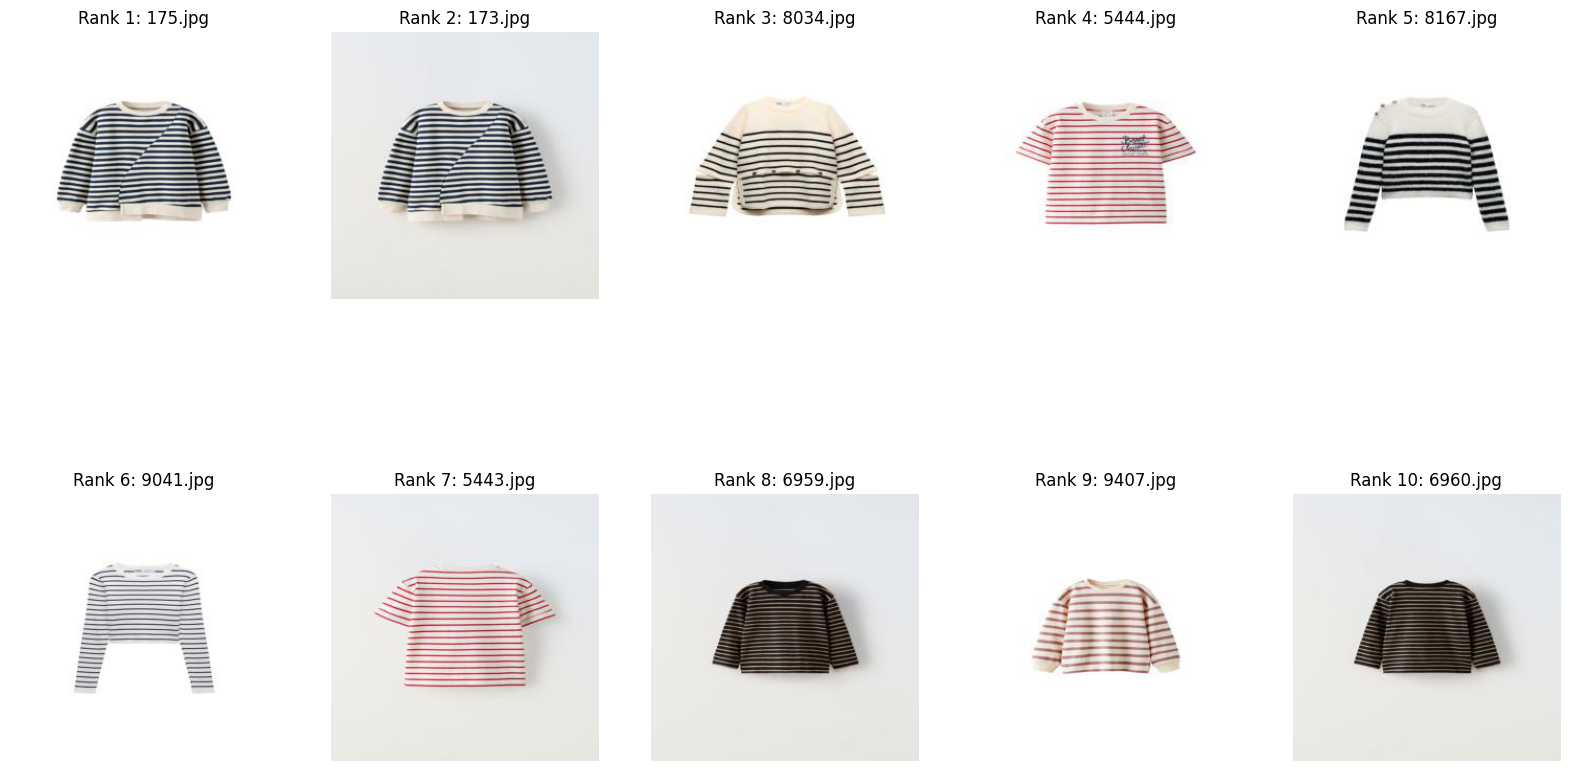

In [69]:
print("Top 10 similar images with pretrained model:")
similar_images = top_k_similar_images(pretrained_matrix, specific_image_name="175.jpg", k=10)

Top 10 similar images with finetunned model:


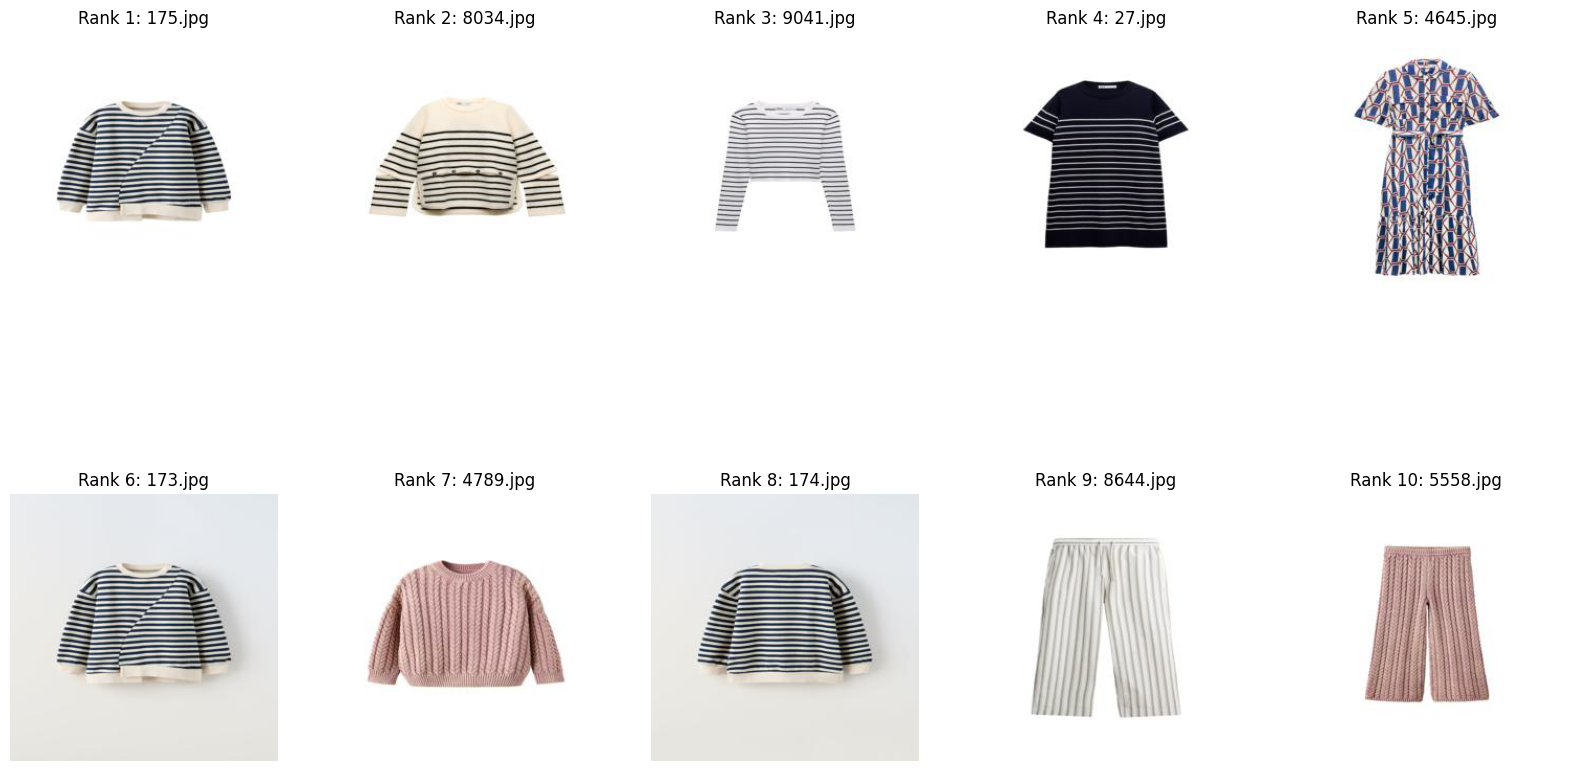

In [70]:
print("Top 10 similar images with finetunned model:")
similar_images = top_k_similar_images(finetunning_matrix, specific_image_name="175.jpg", k=10)